
# MICCAI 2024 INR Tutorial
Welcome to the official notebook on Implicit Neural Representations (INR) for the MICCAI 2024 INR4MICCAI Tutorial.

**Author**: Nil Stolt-Ansó   
**Contributors**: Thanks to Wenqi Huang for code contributions to the k-space section, as well as the review efforts by Julian McGinnis and Vasili Sideri-Lampretsa.   



# What are Implicit Neural Representations?


INRs are learned mappings from a coordinate system to an arbitrary function.

An INR typically involves a multi-layer perceptron (MLP) being trained to take in a coordinate as input, and output the value of the function at that coordinate.

<center width="100%" style="padding:25px"><img src="https://www.researchgate.net/publication/346302971/figure/download/fig1/AS:961682037829650@1606294273728/An-illustration-of-an-image-represented-in-the-implicit-neural-representation-INR-form.png" width="400px"></center>

Once trained, we no longer need the explicit data it was trained on. The INR can be said to be __implicitly__ representing the function in the weights of the neural network, hence its name.

The type of functions we try to represent wildly vary depending on the application:
*   Image intensities (gray-scale, RGB, ...)
*   Shapes (occupancy values, signed distances, ...)
*   Vector fields (deformations, velocities, ...)




# Training a simple INR

In this section we will train our first INR on medical images from the MedMNIST dataset. We will take a look at the structure of the training data, build a simple training loop, and plot the reconstructions of our learned representation.


In [1]:
# Colab requirements:
# !apt-get install git
# !pip install medmnist --quiet
# !pip install torch --quiet
# !pip install torchvision --quiet
# !pip install lightning  --quiet
# !pip install matplotlib --quiet
# !pip install scipy==1.11.3 --quiet
# !pip torchkbnufft scipy==1.11.3 --quiet
# import torch
# torch.cuda.is_available()


## INR architecture

Lets begin by creating our INR architecture.

Implicit Neural Representations are typically defined as a series of dense layers with non-linear activation functions. The network is meant to learn a mapping between coordinates and the value of a function at those coordinates.


We will start by creating a network with ReLU layers. As we will see later in this tutorial, the naive use of Rectified Linear Units (ReLU) does not produce ideal results. For this reason, we will allow our INR class to make use of easily-swappable layers in make use of fancier layers later in the tutorial.

In [1]:
import torch
from torch import nn

class ReLULayer(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 **kwargs):
        super().__init__()
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear(x)
        x = torch.relu(x)
        return x


class MLP(nn.Module):
    def __init__(self,
                 in_size: int,
                 out_size: int,
                 hidden_size: int = 128,
                 num_layers: int = 3,
                 layer_class: nn.Module = ReLULayer,
                 **kwargs):
        super().__init__()

        a = [layer_class(in_size, hidden_size, **kwargs)]
        for i in range(num_layers - 1):
            a.append(layer_class(hidden_size, hidden_size, **kwargs))
        a.append(nn.Linear(hidden_size, out_size))
        self.layers = nn.ModuleList(a)        

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x


## Data loading

For starters, we will use the ChestMNIST dataset. A dataset of gray-scale chest X-ray images.

Unlike other areas of machine learning, we don't aim to generalize to unseen subjects. INRs are trained on exclusively one subject and aim to generalize onto unseen coordinates.

We will thus download only 1 image and aim to see how well the network is able to interpolate the image into arbitrary resolutions.


Using downloaded and verified file: C:\Users\nilst\.medmnist\pneumoniamnist_224.npz
Image shape: torch.Size([224, 224, 1])
Max: tensor(0.8980) Min: tensor(0.)


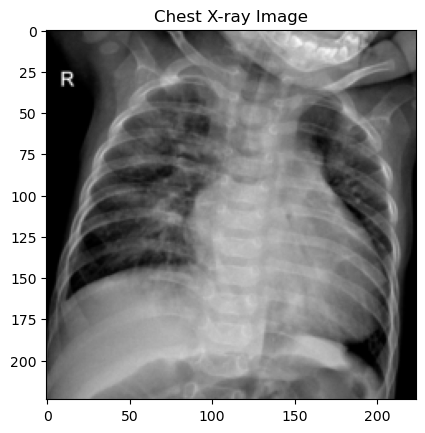

In [9]:
from medmnist import BreastMNIST, RetinaMNIST, PneumoniaMNIST
from torchvision.transforms.functional import pil_to_tensor
import matplotlib.pyplot as plt

IMAGE_SIZE = 224  # ChestMNIST offers sizes: 28, 64, 128, 224
chest_dataset = PneumoniaMNIST(split="val",
                           download=True,
                           size=IMAGE_SIZE)

# INRs are trained on only 1 scene. We only want 1 image.
pil_image, _ = chest_dataset[1]

gt_image = pil_to_tensor(pil_image)
gt_image = gt_image.moveaxis(0, -1)  # Convert to torch.Tensor
gt_image = gt_image.to(torch.float32) / 255.0  # Normalize image between [0.0, 1.0]
print("Image shape:", gt_image.shape)
print("Max:", gt_image.max(), "Min:", gt_image.min())
plt.imshow(gt_image, cmap='gray')
plt.title('Chest X-ray Image')
plt.show()



Since the network takes in only takes in one coordinate at a time, we want our dataloader to yield batches of coordinate-value pairs (as opposed to pairs of whole images and their coorresponding ground-truths like in other areas of supervised learning).


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np


POINTS_PER_SAMPLE = 2048

class RandomPointsDataset(Dataset):
    def __init__(self, image: torch.Tensor, points_num: int = POINTS_PER_SAMPLE):
        super().__init__()
        self.device = "cpu"
        self.points_num = points_num
        assert image.dtype == torch.float32
        self.image = image.to(self.device)  # (H, W, ..., C)
        self.dim_sizes = self.image.shape[:-1]  # Size of each spatial dimension

        # To help us define the input/output sizes of our network later
        # we store the size of our input coordinates and output values
        self.coord_size = len(self.image.shape[:-1])  # Number of spatial dimensions
        self.value_size = self.image.shape[-1]  # Channel size

    def __len__(self):
        return 1

    def __getitem__(self, idx: int):
        # Create random sample of pixel indices
        point_indices = [torch.randint(0, i, (self.points_num,), device=self.device) for i in self.dim_sizes]

        # Retrieve image values from selected indices
        point_values = self.image[tuple(point_indices)]

        # Convert point indices into normalized [-1.0, 1.0] coordinates
        point_coords = torch.stack(point_indices, dim=-1)
        spatial_dims = torch.tensor(self.dim_sizes, device=self.device)
        point_coords_norm = point_coords / (spatial_dims / 2) - 1

        # The subject index is also returned in case the user wants to use subject-wise learned latents
        return point_coords_norm, point_values

dataset = RandomPointsDataset(gt_image, points_num=POINTS_PER_SAMPLE)
# We set a batch_size of 1 since our dataloader is already returning a batch of points.
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, pin_memory=True)


## Optimization

Finally, we will use Pytorch Lightning to create simple training procedure. We will use the Adam optimizer with a learning rate of 0.001.

As we train, we will plot the reconstructed images at certain intervals to visualize the reconstruction fidelity of our INR.

In [4]:
from typing import Tuple, List, Optional
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import lightning as pl
from datetime import datetime

HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 5000


In [5]:
# We will track visual results every few epochs and visualize them after training
def plot_reconstructions(progress_ims: List[Tuple[int, np.ndarray]], gt_im: np.ndarray, scores: Optional[List[float]] = None):
    ncols = len(progress_ims) + 1
    fig_width = 5
    fig, axs = plt.subplots(ncols=ncols, figsize=(ncols*fig_width, fig_width))
    for i, (epoch, im) in enumerate(progress_ims):
        ax = axs[i]
        ax.imshow(im, cmap='gray')
        ax.axis('off')
        title = f'Epoch: {epoch}'
        if scores is not None:
            title += f', PSNR: {scores[epoch-1]}'
        ax.set_title(title)

    axs[-1].imshow(gt_im, cmap='gray')
    axs[-1].axis('off')
    axs[-1].set_title('Ground Truth')
    plt.tight_layout()
    plt.show()

# We will also track the PSNR of our training samples
def psnr(img1, img2, max_value=1.0):
  mse = torch.mean((img1 - img2) ** 2)
  if mse == 0:
    return float('inf')
  return 20 * torch.log10(max_value / torch.sqrt(mse))

# Let's create a function to plot our psnr scores throughout training
def plot_psnr_scores(models: List['INRModule'], avg_window: int = 10):
    fig, ax = plt.subplots()
    for model in models:
        averaged_scores = np.array(model.psnr_scores).reshape(-1, avg_window).mean(-1)
        x = np.arange(0, len(model.psnr_scores), avg_window)
        ax.plot(x, averaged_scores, label=model.name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR')
    ax.set_title('PSNR Scores')
    ax.legend()
    plt.show()

In [6]:
class INRModule(pl.LightningModule):
    def __init__(self,
                 network: MLP,
                 name='',
                 lr=0.001,
                 sampling_resolution=[224, 224],
                 visualization_intervals=[50, 200, 1000, 5000, 15000, 50000],
                ):
        super().__init__()
        self.name = name
        self.sampling_resolution = sampling_resolution
        self.visualization_intervals = visualization_intervals
        self.lr = lr
        self.network = network
        self.progress_ims = []
        self.psnr_scores = []

    def configure_optimizers(self):
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        return self.network(coords)

    def training_step(self, batch, batch_idx):
        coords, values = batch
        coords = coords.view(-1, coords.shape[-1])
        values = values.view(-1, values.shape[-1])
        outputs = self.forward(coords)
        loss = nn.functional.mse_loss(outputs, values)
        self.psnr_scores.append(psnr(outputs, values).cpu().item())  # Log PSNR
        return loss

    def on_train_epoch_end(self):
        """ At each visualization interval, reconstruct the image using our INR """
        if self.current_epoch + 1 in self.visualization_intervals:
            pred_im = self.sample_at_resolution(self.sampling_resolution)
            pred_im = pred_im.cpu().numpy()
            self.progress_ims.append((self.current_epoch+1, pred_im))

    @torch.no_grad()
    def sample_at_resolution(self, resolution: Tuple[int, ...]):
        """ Evaluate our INR on a grid of coordinates in order to obtain an image. """
        meshgrid = torch.meshgrid([torch.arange(0, i, device=self.device) for i in resolution], indexing='ij')
        coords = torch.stack(meshgrid, dim=-1)
        coords_norm = coords / torch.tensor(resolution, device=self.device) * 2 - 1
        coords_norm_ = coords_norm.reshape(-1, len(meshgrid))
        predictions_ = self.forward(coords_norm_)
        predictions = predictions_.reshape((*resolution, -1))
        return predictions


In [11]:
inr = MLP(dataset.coord_size,
          dataset.value_size,
          hidden_size=HIDDEN_SIZE,
          num_layers=NUM_LAYERS,
          layer_class=ReLULayer, 
         )
inr_module = INRModule(network=inr,
                       name='ReLU',
                       lr=LEARNING_RATE,
                       sampling_resolution=[IMAGE_SIZE, IMAGE_SIZE],
                      )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(inr_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 33.5 K
---------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)
C:\Users\nilst\.conda\envs\cmr_ia\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nilst\.conda\envs\cmr_ia\lib\site-packages\lightning\pytorch\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (1) 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


Fitting time: 0:00:16.258387s.


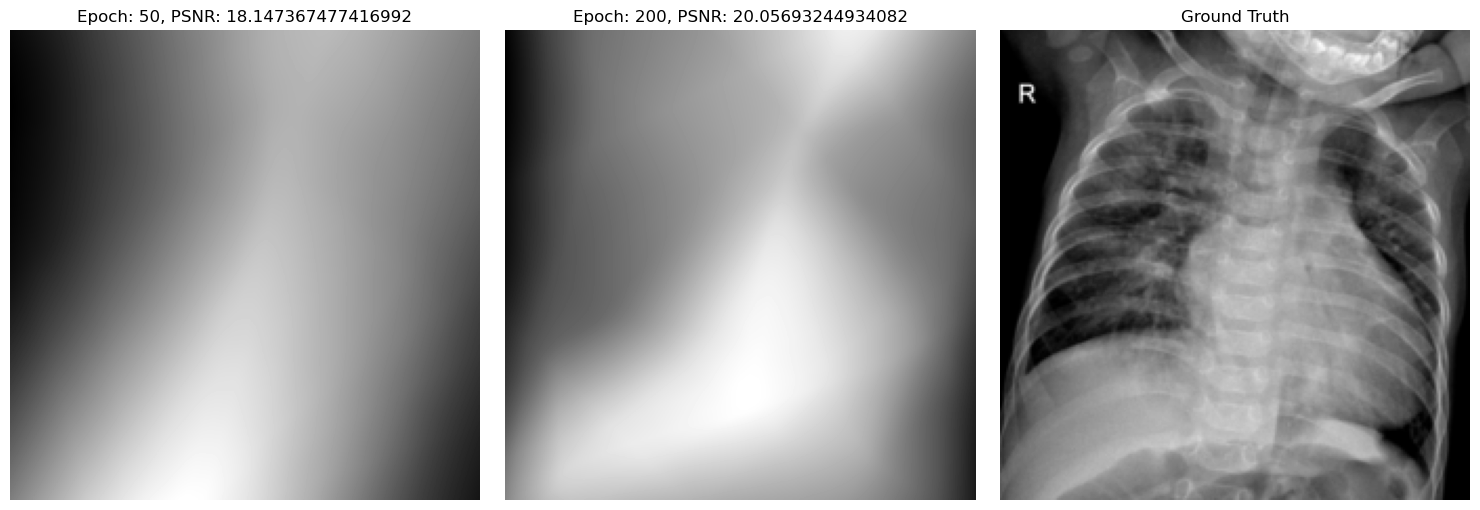

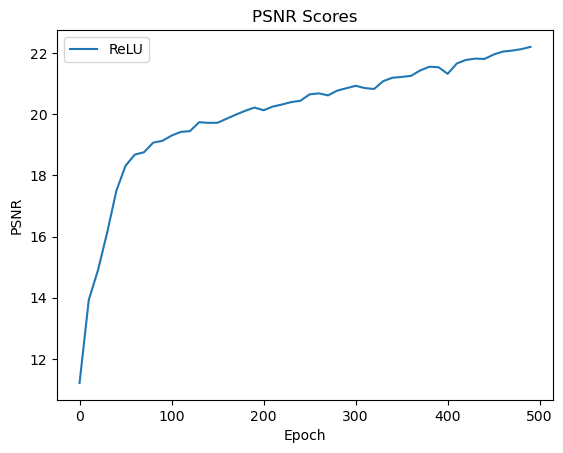

In [12]:
# Let's visualize the reconstruction progress during training!
plot_reconstructions(inr_module.progress_ims, gt_image.cpu().numpy(), inr_module.psnr_scores)
plot_psnr_scores([inr_module])

# Architectural Improvements

Standard MLPs are known to fail to model the high frequency components of signals. This *spectral bias* causes INRs to produce blurry reconstructions such as the ones from our trained model above.

Let's see what can be done to improve reconstruction fidelity.


## Activation functions

Multiple papers propose alternate activation functions as a drop-in replacement for ReLU layers. These approaches base themselves on signal processing concepts and offer improvements in terms of robustness and reconstruction fidelity.   

### SIREN

One such INR variant are sinusoidal representation networks (SIREN) as proposed by the paper [*Implicit Neural Representations with Periodic Activation Functions*](https://www.vincentsitzmann.com/siren/). SIRENs replace ReLU activation functions with sinusoids.

<!-- <center width="100%" style="padding:25px"><img src="https://bmild.github.io/fourfeat/img/teaser.png" width="750px"></center>
 -->
<video id="" width="50%" autoplay="true" loop="true" muted="" controls="" src="https://www.vincentsitzmann.com/siren/img/bikes_comparison_label.mp4" type="video/mp4"> </video>

One important parameter to take into account is the *siren factor* $\omega_0$ which is used to scale the frequency of our layer activations. We can use this parameter to make the network better learn high spatial frequency components. A higher value of $\omega_0$ will allow the network to capture high-frequency components, but it will also introduce noisy artifacts into our reconstruction. The authors empirically propose a value of $\omega_0 = 30.0$.



In [25]:
SIREN_FACTOR = 31.0

class SineLayer(nn.Module):
    """
        Implicit Neural Representations with Periodic Activation Functions
        Implementation based on https://github.com/vsitzmann/siren?tab=readme-ov-file
    """
    def __init__(self, in_size, out_size, siren_factor=30., **kwargs):
        super().__init__()
        # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of factor 30
        self.siren_factor = siren_factor
        self.linear = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        x = self.linear(x)
        x = torch.sin(self.siren_factor * x)
        return x



The authors also emphasize the initialization of the weights as having a large impact on the convergence of the SIREN. Every layer after the first should be initialized with a distribution dependent on the $\omega_0$ value:  

$$ \hat{W} \sim \mathcal{U}\left(-\sqrt{\frac{c}{\omega_0^2 n}}, \sqrt{\frac{c}{\omega_0^2 n}}\right) $$

The authors propose a value of $c=6$.

We can then initialize our SIREN weights with the following function.

In [26]:
import math

def initialize_siren_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].linear.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].linear.weight.size(-1)
        network.layers[0].linear.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization uses based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.linear.weight.size(-1)
            layer.linear.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].linear.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

In [12]:
# We use the same MLP class as before, but give it our new SIREN layers
siren_inr = MLP(dataset.coord_size,
                dataset.value_size,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                layer_class=SineLayer, 
                siren_factor=SIREN_FACTOR,
                )
# Re-initialize the weights and make sure they are different
initialize_siren_weights(siren_inr, SIREN_FACTOR)

siren_module = INRModule(network=siren_inr,
                         name='SIREN',
                         lr=LEARNING_RATE,
                         sampling_resolution=[IMAGE_SIZE, IMAGE_SIZE],
                        )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(siren_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 33.5 K
---------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


31.0
31.0
31.0


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:01:50.971766s.


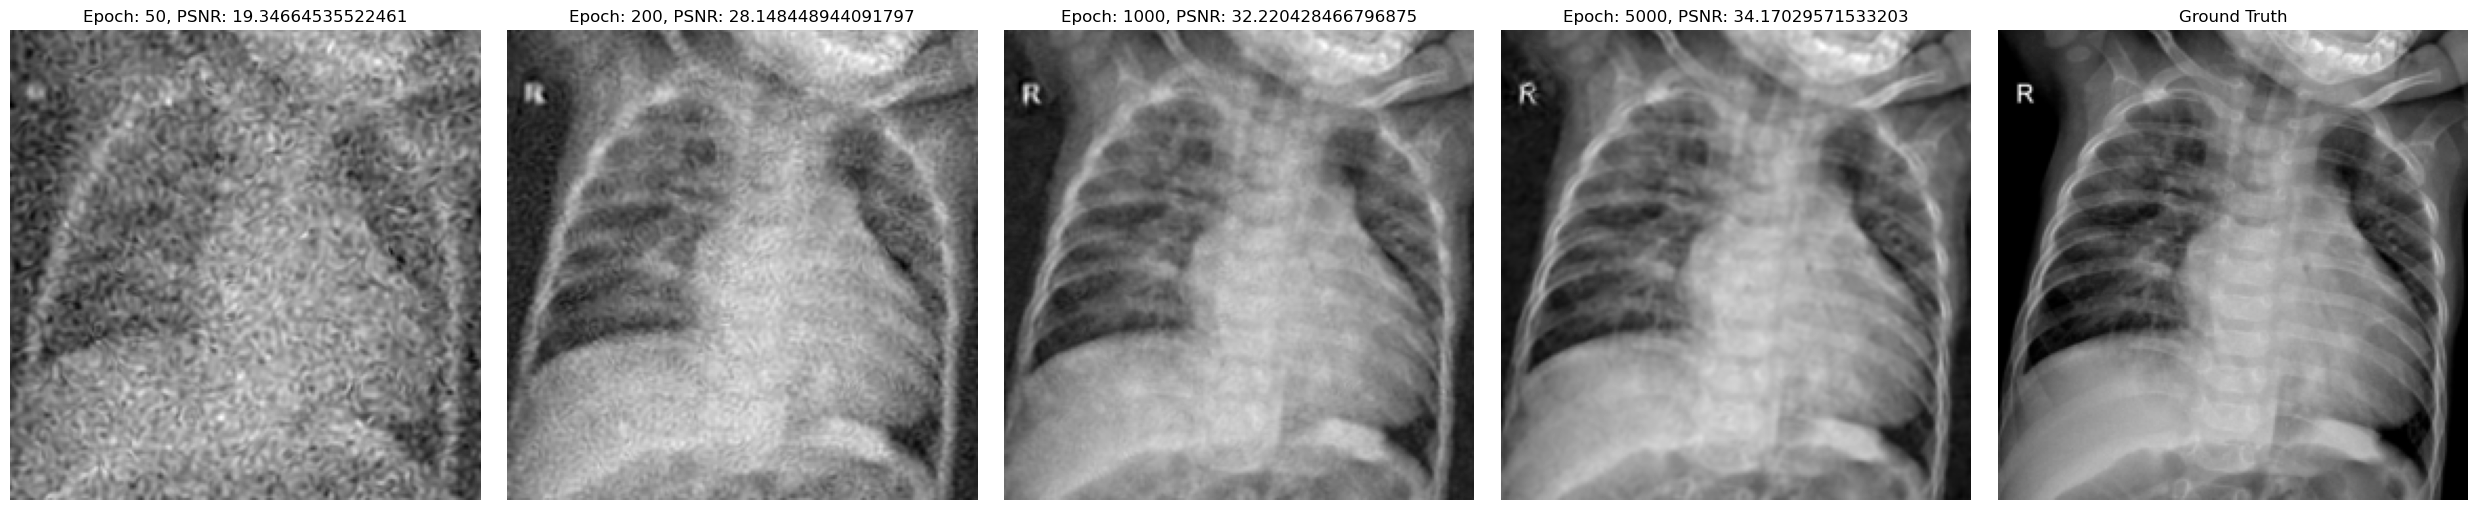

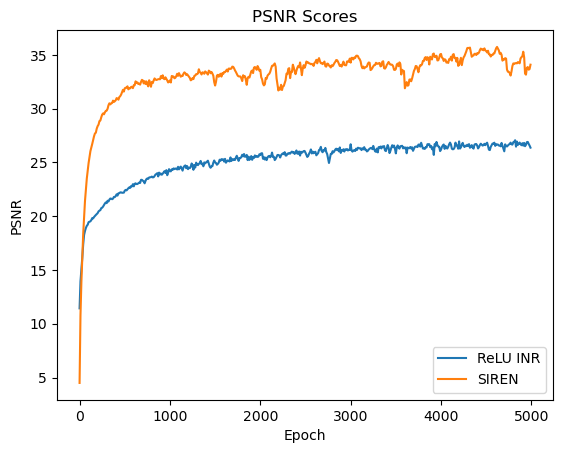

In [69]:
plot_reconstructions(siren_module.progress_ims, gt_image.cpu().numpy(), siren_module.psnr_scores)
plot_psnr_scores([inr_module,
                  siren_module])

### WIRE

Another popular choice of activation functions are Wavelet Implicit Neural Representations (WIRE) as proposed by the paper [*WIRE: Wavelet Implicit Neural Representations*](https://vishwa91.github.io/wire). WIRE extends SIRENs by applying a Gaussian window over the sinusoidal activation function. This creates a localized waveform that oscillates within a specific region and decays smoothly outside of it. This localization helps to reduce the global influence of each activation, preventing the ringing artifacts that can occur with purely sinusoidal activations.

<center width="100%" style="padding:25px"><img src="https://vishwa91.github.io/files/wire/wire1.png" width="750px"></center>

The authors discuss useful priors of wavelet activations such as robustness to noise. 
<center width="100%" style="padding:25px"><img src="https://vishwa91.github.io/files/wire/wire_ct.png" width="750px"></center>

These activation functions come with two important hyper-parameters. Similar to our SIREN layers, the $\omega$ parameter determines the frequency of the wavelet. The $\sigma$ parameter determines the width of the wavelet.


In [27]:
WIRE_OMEGA = 20.0
WIRE_SIGMA = 10.0

class WIRELayer(nn.Module):
    """
        Implicit representation with Gabor nonlinearity
        Implementation based on https://github.com/vishwa91/wire
    """
    def __init__(self, in_size, out_size, wire_omega: float = 30.0, wire_sigma: float = 40.0, **kwargs):
        super().__init__()
        self.omega_0 = wire_omega  # Frequency of wavelet
        self.scale_0 = wire_sigma  # Width of wavelet
        self.freqs = nn.Linear(in_size, out_size, bias=True)
        self.scale = nn.Linear(in_size, out_size, bias=True)

    def forward(self, x):
        omega = self.omega_0 * self.freqs(x)
        scale = self.scale(x) * self.scale_0
        x = torch.cos(omega) * torch.exp(-(scale * scale))
        return x

In [28]:
import math

def initialize_wire_weights(network: MLP, omega: float):
    """ See SIREN paper supplement Sec. 1.5 for discussion """
    old_weights = network.layers[1].freqs.weight.clone()
    with torch.no_grad():
        # First layer initialization
        num_input = network.layers[0].freqs.weight.size(-1)
        network.layers[0].freqs.weight.uniform_(-1 / num_input, 1 / num_input)
        network.layers[0].scale.weight.uniform_(-1 / num_input, 1 / num_input)
        # Subsequent layer initialization based on omega parameter
        for layer in network.layers[1:-1]:
            num_input = layer.freqs.weight.size(-1)
            layer.freqs.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
            layer.scale.weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        # Final linear layer also uses initialization based on omega parameter
        num_input = network.layers[-1].weight.size(-1)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        network.layers[-1].weight.uniform_(-math.sqrt(6 / num_input) / omega, math.sqrt(6 / num_input) / omega)
        
    # Verify that weights did indeed change
    new_weights = network.layers[1].freqs.weight
    assert (old_weights - new_weights).abs().sum() > 0.0

In [86]:
# We use the same MLP class as before, but give it our new SIREN layers
wire_inr = MLP(dataset.coord_size,
               dataset.value_size,
               hidden_size=HIDDEN_SIZE*5//7, # WIRE layers have 2 linear components, try to roughly have the same #params as our other baselines
               num_layers=NUM_LAYERS,
               layer_class=WIRELayer, 
               wire_omega=WIRE_OMEGA,
               wire_sigma=WIRE_SIGMA,
               )
initialize_wire_weights(wire_inr, WIRE_OMEGA)
wire_module = INRModule(network=wire_inr,
                        name='WIRE',
                        lr=LEARNING_RATE,
                        sampling_resolution=[IMAGE_SIZE, IMAGE_SIZE],
                       )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(wire_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type | Params
---------------------------------
0 | network | MLP  | 34.1 K
---------------------------------
34.1 K    Trainable params
0         Non-trainable params
34.1 K    Total params
0.137     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:02:11.963707s.


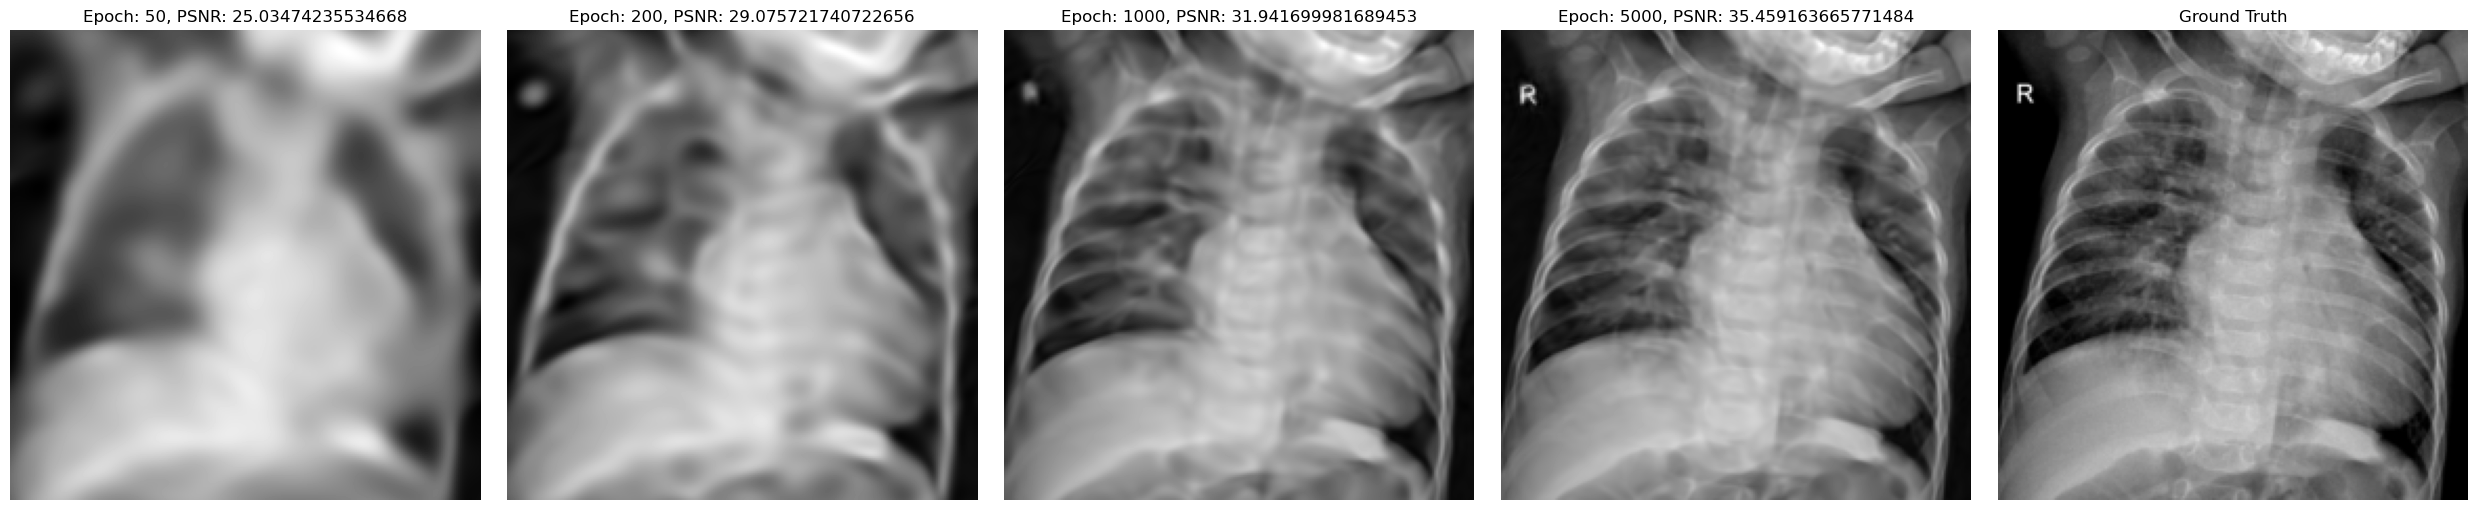

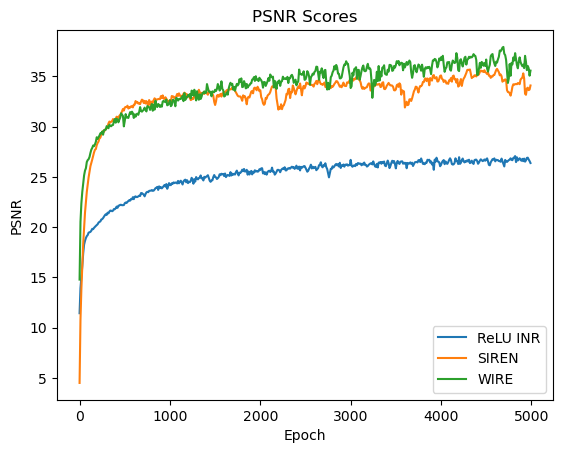

In [87]:
plot_reconstructions(wire_module.progress_ims, gt_image.cpu().numpy(), wire_module.psnr_scores)
plot_psnr_scores([inr_module,
                  siren_module,
                  wire_module])


## Positional Encoders

One simple architectural change is the addition of positional encoders. These are coordinate mappings that help emphasize suddle changes in coordinates to the network.

One popular choice of positional encoder are [Fourier Features](https://bmild.github.io/fourfeat/).


<center width="100%" style="padding:25px"><img src="https://bmild.github.io/fourfeat/img/teaser.png" width="750px"></center>

Fourier feature mappings use a random Gaussian matrix $B$ that map low-dimensional coordinates $v$ to high-dimensional fourier spaces before passing them into the network:

$$
\gamma(\mathbf{v})=[\cos (2 \pi \mathbf{B v}), \sin (2 \pi \mathbf{B v})]^{\mathrm{T}}
$$

The scale of the Gaussian matrix helps us control the amount of underfitting/overfitting on high-frequency details.


<video id="v0" width="100%" autoplay="1" loop="1" muted="" controls="" src="https://bmild.github.io/fourfeat/img/test_sweep_1e-4_5000_more_low.mp4" type="video/mp4"> </video>

Fourier features can be implemented using a few lines of code. They make ReLU INRs achieve perfomance comparable to SIREN or WIRE INRs. 

In [13]:
FF_FREQS = 128
FF_SCALE = 1.0

class FourierFeatures(nn.Module):
    """ Positional encoder from Fourite Features [Tancik et al. 2020]
     Implementation based on https://github.com/tancik/fourier-feature-networks/blob/master/Demo.ipynb """
    def __init__(self,
                 coord_size: int,
                 freq_num: int,
                 freq_scale: float = 1.0):
        super().__init__()
        self.freq_num = freq_num  # Number of frequencies
        self.freq_scale = freq_scale  # Standard deviation of the frequencies
        self.B_gauss = torch.normal(0.0, 1.0, size=(coord_size, self.freq_num)) * self.freq_scale

        # Pre-compute the 2pi multiplication so we don't have to do it every forward pass
        self.B_gauss_pi = 2. * np.pi * self.B_gauss

        # We store the output size of the module so that the INR knows what input size to expect
        self.out_size = 2 * self.freq_num

    def forward(self, coords):
        # Map the coordinates to a higher dimensional space using the randomly initialized features
        prod = coords @ self.B_gauss_pi.to(coords.device)
        # Pass the features through a sine and cosine function
        out = torch.cat((torch.sin(prod), torch.cos(prod)), dim=-1)
        return out

We reuse our `INRModule` Lightning module from above by adding the additional positional encoder and modifying the `forward()` function.

In [14]:
class PosEncINRModule(INRModule):
    """ INR with Fourier Feature positional encoding """
    def __init__(self,
                 pos_encoder: nn.Module,
                 network: MLP,
                 **kwargs):
        super(PosEncINRModule, self).__init__(network=network, **kwargs)
        self.pos_encoder = pos_encoder

    def configure_optimizers(self):
        # Note that we do NOT optimize the positional encoder's parameters.
        return torch.optim.Adam(self.network.parameters(), lr=self.lr)

    def forward(self, coords):
        # Apply positional encoding, then apply network
        pos_enc_coords = self.pos_encoder(coords)
        return self.network(pos_enc_coords)


In [20]:
ff_pos_enc = FourierFeatures(dataset.coord_size, freq_num=FF_FREQS)
ff_relu_inr = MLP(ff_pos_enc.out_size,
               dataset.value_size,
               hidden_size=HIDDEN_SIZE,
               num_layers=NUM_LAYERS,
               layer_class=ReLULayer,
               )
ffinr_module = PosEncINRModule(pos_encoder=ff_pos_enc,
                               network=ff_relu_inr,
                               name='FF+ReLU',
                               lr=LEARNING_RATE,
                               sampling_resolution=[IMAGE_SIZE, IMAGE_SIZE],
                              )
trainer = pl.Trainer(max_epochs=TRAINING_EPOCHS)
s = datetime.now()
trainer.fit(ffinr_module, train_dataloaders=dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params
------------------------------------------------
0 | network     | MLP             | 66.0 K
1 | pos_encoder | FourierFeatures | 0     
------------------------------------------------
66.0 K    Trainable params
0         Non-trainable params
66.0 K    Total params
0.264     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5000` reached.


Fitting time: 0:01:46.580710s.


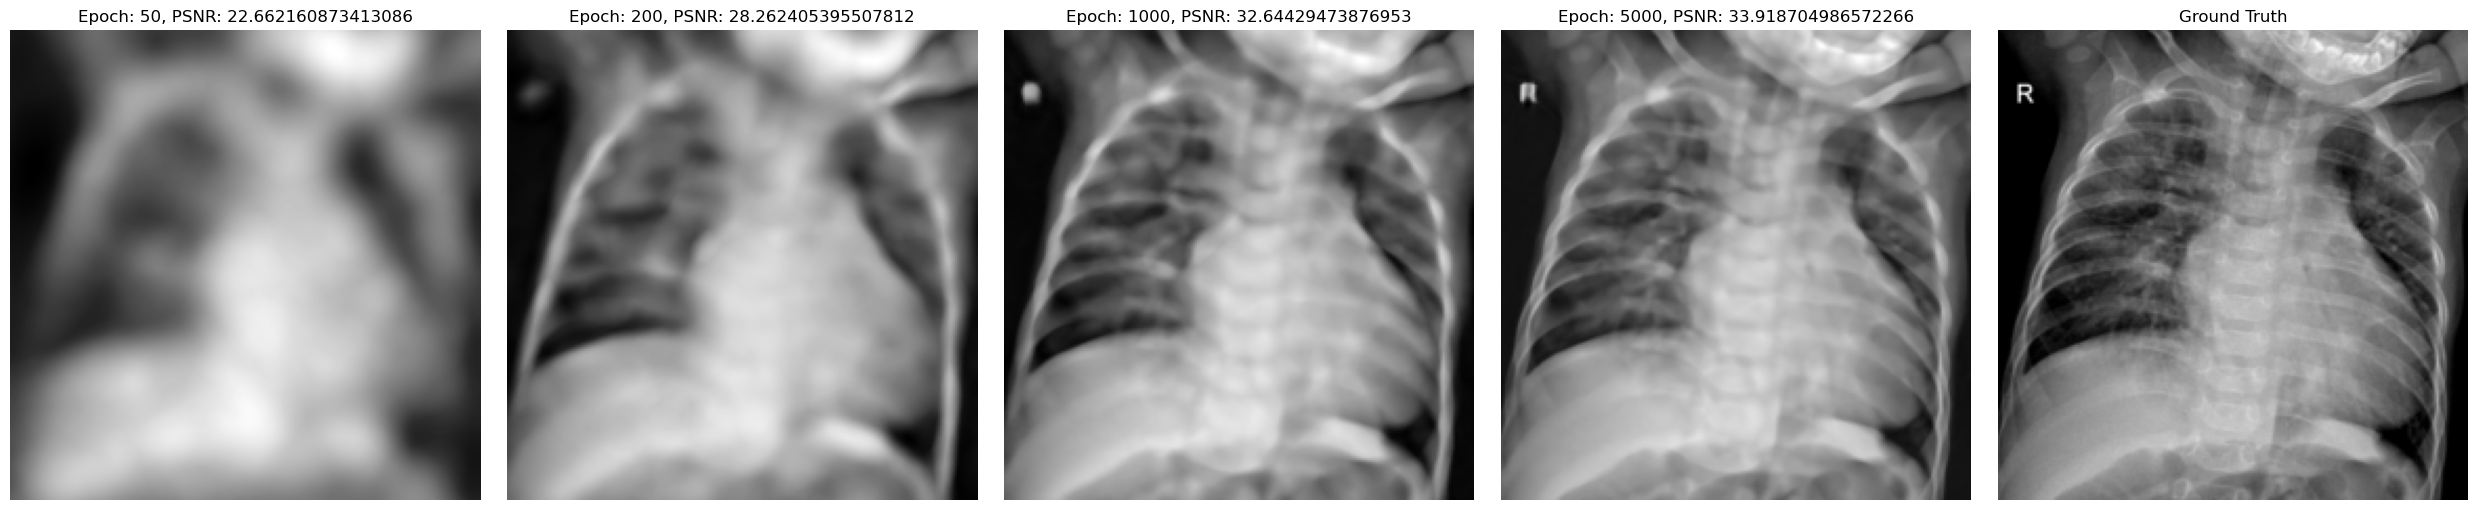

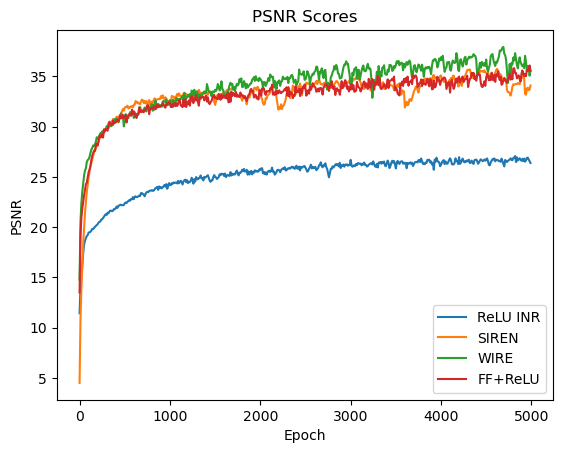

In [88]:
plot_reconstructions(ffinr_module.progress_ims, gt_image.cpu().numpy(), ffinr_module.psnr_scores)
plot_psnr_scores([inr_module,
                  siren_module,
                  wire_module,
                  ffinr_module])

# INRs for interpolation

One application of INRs is data interpolation. Once the INR is trained, we can resample the image at any arbitrary resolution we want. So far we've been applying our INR to a simple image, however plenty of simpler interpolation algorithms already exist that can be applied to grids.

INRs shine in modalities with non-standard or unstructured data. In medical imaging there are lots of domains with non-standard sampling strategies. Meanwhile, our imaging tools often provide well-calibrated coordinate system along-side the image information.

This makes INRs specially well-suited more many medical imaging tasks, as once trained, they provide the ability to resample an image at any coordinates we want.

One such example of a domain is magnetic resonance imaging (MRI). MRI data is sampled in the frequency domain (otherwise known as K-space). A Fourier transform is then performed to reconstruct the image from the spatial frequency data. (The following images are borrowed from [mri.questions.com](https://mriquestions.com/), which offers a great introduction to MRI and the underlying physics.)

<center width="100%" style="padding:25px"><img src="https://s.mriquestions.com/uploads/3/4/5/7/34572113/4956435.jpg?597" width="550px"></center>

In order to perform the Fourier transform, our K-space data needs to be in a Cartesian grid. However, not all sampling patterns follow a regular grid. One such example is *radial sampling*.

<table style="width: 100%; border-collapse: collapse;">
  <tr>
    <td style="width: 50%; text-align: center; padding: 10px;">
      <img src="https://mriquestions.com/uploads/3/4/5/7/34572113/editor/kspace-cartesian.gif?1501763922" width="250" alt="Cartesian sampling of k-space">
      <br>
      <span style="display: inline-block; font-size: 90%; margin-top: 10px;">Cartesian sampling of <i>k</i>-space</span>
    </td>
    <td style="width: 50%; text-align: center; padding: 10px;">
      <img src="https://mriquestions.com/uploads/3/4/5/7/34572113/kspace-radial-filling_orig.gif" width="250" alt="Radial sampling of k-space">
      <br>
      <span style="display: inline-block; font-size: 90%; margin-top: 10px;">Radial sampling of <i>k</i>-space</span>
    </td>
  </tr>
</table>


Radial sampling samples K-space lines in a rotating fashion about the center of the space. These radial lines are called _spokes_. A downside of radial sampling is having to interpolate our samples into a grid in order to perform the Fourier transform. 

Furthermore, a common practice in MRI is to accelerate the acquisition process by purposely undesampling the K-space. This comes at the cost of having to further interpolate our K-space, which introduces noise into our reconstruction. 

In this section we will reproduce [a 2023 paper by W. Huang](https://arxiv.org/pdf/2212.08479), which makes use of INRs to interpolate undersampled radial K-space data. In their paper, they apply an INR to a 2D+time cardiac data, showing that:
- INRs have stronger priors than traditional interpolation techniques.
- INRs can produce clear reconstructions on a **single-subject** training setting (as opposed to dataset-based approaches is typical deep learning approaches).

<center width="100%" style="padding:25px"><img src="https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-031-34048-2_42/MediaObjects/538831_1_En_42_Fig1_HTML.png?as=webp" width="550px"></center>


## Data preparation
We will begin by downloading and preprocessing a K-space dataset for a single subject from the Harvard Medical School's [Cardiac MR Center Dataverse](https://dataverse.harvard.edu/dataverse/cardiacmr).

In [15]:
import os

current_dir = os.getcwd()
download_dir = os.path.join(current_dir, 'data_download')
os.makedirs(download_dir, exist_ok=True)
file_name = os.path.join(download_dir, 'radial_dataset.mat')


In [16]:
# We'll try to download using a headless Chrome browser.
# If this doesn't work, you should manually copy and paste the url to your 
# browser to start the download, then copy the file to the file_name location listed above.

url = r'https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/CI3WB6/XS8ZVS'

if not os.path.exists(file_name):
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    import time
    
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_experimental_option("prefs", {
        "download.default_directory": download_dir,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": False
    })
    
    driver = webdriver.Chrome(options=chrome_options)
    driver.get(url)
    
    time.sleep(5)
    download_path = os.path.join(download_dir, os.listdir(download_dir)[-1])
    
    def wait_for_download(file_path, timeout=120, expected_size='233320724'):
        """Wait for the file to be downloaded completely."""
        end_time = time.time() + timeout
        while time.time() < end_time:
            print(f'File size: {os.path.getsize(file_path)} / 233320724', end='\r')
            if int(os.path.getsize(file_path)) == int(expected_size):
                return True
            time.sleep(1)
        return False
        
    # Wait for the download to complete
    print("Downloading to:", download_dir)
    if wait_for_download(download_path):
        os.rename(download_path, file_name)
        assert os.path.getsize(file_name) > 0
        print(f"File downloaded successfully to {file_name}")
    else:
        print("File download failed or timed out")
    
    driver.quit()

In [17]:
# Let's load the data from its .map file and convert it to numpy
import scipy.io as sio
import numpy as np
import torch

mat_file = sio.loadmat(file_name)
full_kdata = mat_file['data'].astype(np.complex64)

# The data is a multi-coil 2D+time slice with the following dimensions:
print(full_kdata.shape)
# (#slices, #frames, #samples_per_line, #radial_lines, #coils, real_and_imaginary_components)

# Get rid of slice dimension, convert to complex, and reshape
full_kdata = full_kdata.squeeze(0)
full_kdata = full_kdata[...,0] + 1j*full_kdata[...,1]  # convert to complex
full_kdata = np.transpose(full_kdata, (0, 3, 2, 1))  # (nphases, nspokes, spoke_len, ncoil)
print("Full data shape:", full_kdata.shape)
# Each of the 25 time frames has 16 coil images, and each coil image has 832*196 samples 
print("Number of frames:", full_kdata.shape[0])
print("Number of coils:", full_kdata.shape[1])
print("Number of spokes:", full_kdata.shape[2])
print("Number of samples per spoke:", full_kdata.shape[3])

(1, 25, 832, 196, 16, 2)
Full data shape: (25, 16, 196, 832)
Number of frames: 25
Number of coils: 16
Number of spokes: 196
Number of samples per spoke: 832


In [18]:
# Lets generate the coordinates for each of our samples in our spokes

def generate_sample_coordinates(kdata_arr):
    nphases, ncoils, nspokes, spoke_len = kdata_arr.shape
    # Calculate the angle of each spoke (in rad)
    spoke_angles = np.linspace(0, np.pi, nspokes, endpoint=False)   # not 2pi because the trajectory is symmetric
    
    # calculate the k-space coordinates of each point in each spoke
    unit_vectors = np.stack([np.cos(spoke_angles), np.sin(spoke_angles)], axis=-1)  # (nspokes, 2)
    distance_to_center = np.linspace(-1, 1, spoke_len, endpoint=False)    # (spoke_len,)
    traj = unit_vectors[:,None] * distance_to_center[None,:,None]  # (nspokes, spoke_len, 2)
    
    # repeat the trajectory for each frame
    traj = np.repeat(traj[None,...], nphases, axis=0)  # (frames, nspokes, spoke_len, 2)
    return traj

full_ktraj = generate_sample_coordinates(full_kdata)

# Coordinates are shared across each coil.
# Our coordinate shape is thus: (#frames, #spokes, #spoke_len, #xy_coordinates)
print("Coordinates shape:", full_ktraj.shape)


Coordinates shape: (25, 196, 832, 2)


## Interpolation using NUFFT
In order to perform the fourier transform, our radially sampled data needs to be interpolated into a cartesian grid. This is the process performed by non-uniform fast fourier transform (NUFFT).

Lets first interpolate our K-space to visualize what our frequency samples look like.

In [5]:
# The following is just for k-space visualization. We will perform the full NUFFT below.
# To visualize K-space, we need to interpolate into a Cartesian grid

# We'll use the torchkbnufft library, which allows us to use a GPU
import torch
import torchkbnufft as tkbn 

def visualize_cartesian_magnitude(kdata_arr: torch.Tensor, ktraj_arr: torch.Tensor):
    """ This function interpolates our k-space samples into a cartesian grid.
        Then, it combines all coil channels and returns only the magnitude of the k-space. 
    """
    kdata_arr = torch.from_numpy(kdata_arr)
    ktraj_arr = torch.from_numpy(ktraj_arr)
    nphases, ncoils, nspokes, spoke_len = kdata_arr.shape
    # Create the forward Interp object
    interp_adj = tkbn.KbInterpAdjoint((spoke_len, spoke_len), (spoke_len, spoke_len))

    # the trajectory is in radians, for torchkbnufft, it should be in the range of [-pi, pi]
    ktraj_arr = ktraj_arr.to(torch.float32) * np.pi  
    print(kdata_arr.shape, ktraj_arr.shape)

    # torchkbufft doesn't care about the nspoke dimension, so we can just flatten it
    kdata_arr = kdata_arr.reshape(nphases, ncoils, spoke_len*nspokes)  # (nphases, ncoil, spoke_len*nspokes)
    ktraj_arr = ktraj_arr.reshape(nphases, spoke_len*nspokes, 2).moveaxis(-1, 1)   # (nphases, 2, spoke_len*nspokes)
    
    # move to GPU if available
    if torch.cuda.is_available():
        kdata_arr = kdata_arr.cuda()
        ktraj_arr = ktraj_arr.cuda()
        interp_adj = interp_adj.cuda()
    
    # calculate the density compensation. This is very slow... and inaccurate...
    print(kdata_arr.shape, ktraj_arr.shape) 
    dcf = tkbn.calc_density_compensation_function(ktraj_arr, im_size=(spoke_len, spoke_len), num_iterations=10)    
    print(kdata_arr.shape, ktraj_arr.shape, dcf.shape) 
    weighted_kdata = kdata_arr * dcf
    
    # Avoid batch-wise nufft to reduce memory footprint
    coil_kspace = torch.zeros((nphases, ncoils, spoke_len, spoke_len), dtype=kdata_arr.dtype, device=kdata_arr.device)
    for i in range(nphases):
        coil_kspace[i:i+1] = interp_adj(weighted_kdata[i:i+1], ktraj_arr[i:i+1])
        
    return coil_kspace.cpu().numpy()

full_kdata_cart = visualize_cartesian_magnitude(full_kdata, full_ktraj)
# Combine coils with root sum of squares
full_kdata_cart = np.sqrt(np.sum(np.abs(full_kdata_cart)**2, axis=1))
print(full_kdata_cart.shape, full_kdata_cart.dtype)


torch.Size([25, 16, 196, 832]) torch.Size([25, 196, 832, 2])
torch.Size([25, 16, 163072]) torch.Size([25, 2, 163072])
torch.Size([25, 16, 163072]) torch.Size([25, 2, 163072]) torch.Size([25, 1, 163072])
(25, 832, 832) float32


Ground-truth k-space


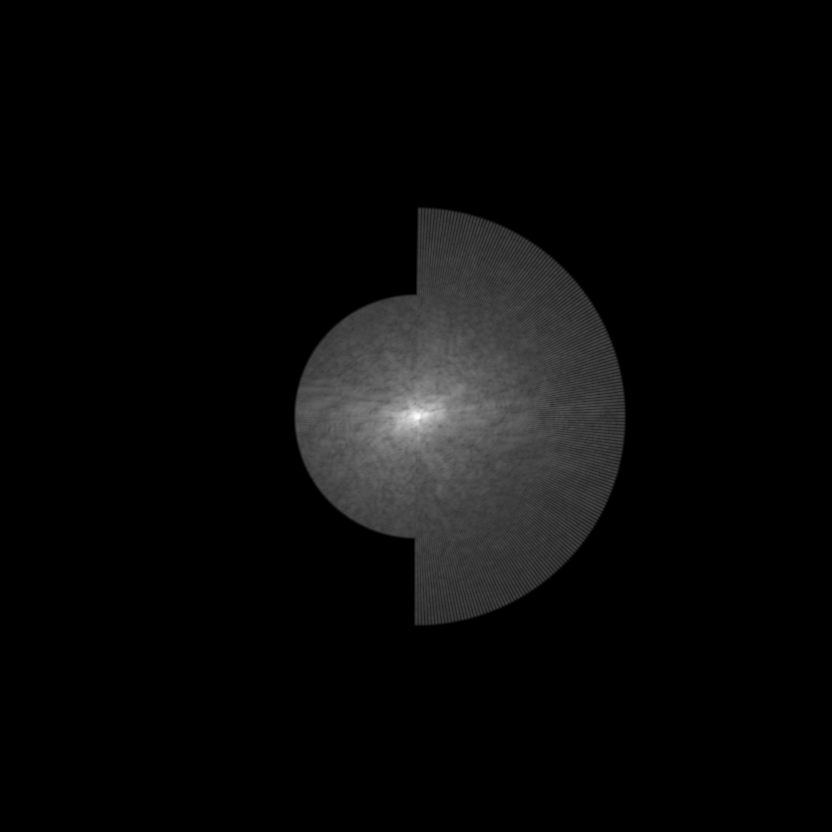

In [6]:
import imageio
from IPython.display import Image, display
from io import BytesIO

def display_array_as_gif(im):

    im_norm = im / im.max()  
    # Convert frames to uint8 and scale to 0-255
    frames = [(im_norm[frame] * 255).astype(np.uint8) for frame in range(im_norm.shape[0])]
    
    bio = BytesIO()
    # Create a GIF in memory
    with imageio.get_writer(bio, format='gif', fps=12, loop=0) as writer:
        for frame in frames:
            writer.append_data(frame)
    bio.seek(0)
    # Display the GIF
    display(Image(data=bio.getvalue(), format='gif', width=400))

print("Ground-truth k-space")
full_kspace_vis = np.fft.fftshift(full_kdata_cart)   # Shift low-freqs to center
full_kspace_vis = np.sqrt(np.sqrt(full_kspace_vis))  # Scale low-frequencies (just for visualization purposes)
display_array_as_gif(full_kspace_vis)
del full_kdata_cart, full_kspace_vis

Let's now visualize what our image really looks like!
First, we make a function to perform the full non-uniform fast Fourier transform (NUFFT).

In [7]:
# We'll use the torchkbnufft library, which allows us to use a GPU
import torch
import torchkbnufft as tkbn 


def nufft(kdata_arr: np.ndarray, ktraj_arr: np.ndarray):
    nphases, ncoils, nspokes, spoke_len = kdata_arr.shape
    
    # Create the forward NUFFT object
    nufft_adj = tkbn.KbNufftAdjoint(im_size=(spoke_len, spoke_len))

    # Convert to tensor
    kdata_arr = torch.from_numpy(kdata_arr).to(torch.complex64)
    # the trajectory is in radians, for torchkbnufft, it should be in the range of [-pi, pi]
    ktraj_arr = torch.from_numpy(ktraj_arr).to(torch.float32) * np.pi  
    print(kdata_arr.shape, ktraj_arr.shape)
    
    # torchkbufft doesn't care about the nspoke dimension, so we can just flatten it
    kdata_arr = kdata_arr.reshape(nphases, ncoils, spoke_len*nspokes)  # (nphases, ncoil, spoke_len*nspokes)
    ktraj_arr = ktraj_arr.reshape(nphases, spoke_len*nspokes, 2).moveaxis(-1, 1)  # (nphases, 2, spoke_len*nspokes)

    # move to GPU if available
    if torch.cuda.is_available():
        kdata_arr = kdata_arr.cuda()
        ktraj_arr = ktraj_arr.cuda()
        nufft_adj = nufft_adj.cuda()

    # calculate the density compensation. This is very slow... and inaccurate...
    dcf = tkbn.calc_density_compensation_function(ktraj_arr, im_size=(spoke_len, spoke_len), num_iterations=10)   
    print(kdata_arr.shape, ktraj_arr.shape, dcf.shape)

    weighted_kdata = kdata_arr * dcf

    # Avoid batch-wise nufft to reduce memory footprint
    coil_img = torch.zeros((nphases, ncoils, spoke_len, spoke_len), dtype=kdata_arr.dtype, device=kdata_arr.device)
    for i in range(nphases):
        coil_img[i:i+1] = nufft_adj(weighted_kdata[i:i+1], ktraj_arr[i:i+1])  # Also very slow... especially on CPU
    
    # Combine coils with root sum of squares
    img = torch.sqrt(torch.sum(torch.abs(coil_img)**2, dim=1))
    return img.cpu().numpy()


full_img = nufft(full_kdata, full_ktraj)
print(full_img.shape, full_img.dtype)


torch.Size([25, 16, 196, 832]) torch.Size([25, 196, 832, 2])
torch.Size([25, 16, 163072]) torch.Size([25, 2, 163072]) torch.Size([25, 1, 163072])
(25, 832, 832) float32


In [8]:
# def ifft(freqs):
#     im = np.zeros_like(freqs)
#     for f in range(freqs.shape[0]):
#         for c in range(freqs.shape[1]):
#             im[f, c] = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(freqs[f, c])))
#     return im

In [9]:
# print("Image reconstruction from ground-truth k-space using NUFFT")
# print(full_kdata_cart.shape, full_kdata_cart.dtype)
# i = ifft(full_kdata_cart)
# i = torch.sqrt(torch.sum(torch.abs(i)**2, dim=1))
# display_array_as_gif(i)

In practice, accelerated images don't look so good. This is because the k-space is undersampled and we have missing information. When less spokes are available, reconstruction artifacts become apparent on our final images.   
Let's simulate an undersampling of our K-space samples by leaving out some spokes each frame.

In [19]:
# Next, let's simulate an undersampling of the data
UNDERSAMPLE_RATIO = 8

# us_kdata = np.zeros((full_kdata.shape[0], full_kdata.shape[1], full_kdata.shape[2] // UNDERSAMPLE_RATIO, full_kdata.shape[3]), dtype=full_kdata.dtype)
# for frame in range(full_kdata.shape[0]):
#     us_kdata[frame] = full_kdata[frame,:, frame % UNDERSAMPLE_RATIO:-UNDERSAMPLE_RATIO//2:UNDERSAMPLE_RATIO,:]  # skip spokes to simulate undersampling
us_kdata = full_kdata[:,:,UNDERSAMPLE_RATIO//2::UNDERSAMPLE_RATIO,:]   # skip spokes to simulate undersampling
us_ktraj = full_ktraj[:,UNDERSAMPLE_RATIO//2::UNDERSAMPLE_RATIO]   # skip spokes to simulate undersampling
# us_kdata = full_kdata[:,:,:10,:]   # skip spokes to simulate undersampling
print("Undersampled data shape:", us_kdata.shape)
# Each of the 25 time frames has 16 coil images, and each coil image has 832*196 samples 
print("Number of frames:", us_kdata.shape[0])
print("Number of coils:", us_kdata.shape[1])
print("Number of spokes:", us_kdata.shape[2])
print("Number of samples per spoke:", us_kdata.shape[3])
del full_kdata, full_ktraj


Undersampled data shape: (25, 16, 24, 832)
Number of frames: 25
Number of coils: 16
Number of spokes: 24
Number of samples per spoke: 832


In [11]:
us_kdata_cart = visualize_cartesian_magnitude(us_kdata, us_ktraj)
us_img = nufft(us_kdata, us_ktraj)


torch.Size([25, 16, 24, 832]) torch.Size([25, 24, 832, 2])
torch.Size([25, 16, 19968]) torch.Size([25, 2, 19968])
torch.Size([25, 16, 19968]) torch.Size([25, 2, 19968]) torch.Size([25, 1, 19968])
torch.Size([25, 16, 24, 832]) torch.Size([25, 24, 832, 2])
torch.Size([25, 16, 19968]) torch.Size([25, 2, 19968]) torch.Size([25, 1, 19968])


In [12]:
print("Undersampled k-space")
us_kspace_vis = np.fft.fftshift(us_kdata_cart)   # Shift low-freqs to center
us_kspace_vis = np.sqrt(np.sqrt(us_kspace_vis))  # Scale low-frequencies for visualization purposes
display_array_as_gif(us_kspace_vis)

print("Image reconstruction from undersampled k-space using NUFFT")

display_array_as_gif(us_img)
del us_kdata_cart, us_kspace_vis

Undersampled k-space


MemoryError: Unable to allocate 2.06 GiB for an array with shape (25, 16, 832, 832) and data type complex64

Notice the obvious undersampling artifacts in the background regions of the image.

## Interpolation using an INR
Now, lets try to train an INR directly on the sparse K-space samples. 

An issue with the naive NUFFT is that the time dimension is completely ignored. Each frame is interpolated independently. However, our network will have access to the time component of the coordinate, allowing it to have an understanding of how neighbouring points relate temporally.

First, let's create our dataset.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import numpy as np

POINTS_PER_SAMPLE = 2048

class RadialDataset(Dataset):
    def __init__(self, image: torch.Tensor, coordinates: torch.Tensor, points_num: int = POINTS_PER_SAMPLE):
        super().__init__()
        assert image.dtype == torch.complex64
        assert coordinates.dtype == torch.float32
        assert image.shape[0] == coordinates.shape[0]
        assert image.shape[2] == coordinates.shape[1]
        assert image.shape[3] == coordinates.shape[2]
        self.device = "cpu"
        self.points_num = points_num
        self.image = image.to(self.device)  # (Time, Coils, Spokes, Spoke_length)
        self.coordinates = coordinates.to(self.device)  # (Time, Spokes, Spoke_length, 2)
        self.dim_sizes = self.image.shape  # Size of each dimension

        # To help us define the input/output sizes of our network later
        # we store the size of our input coordinates and output values
        self.coord_size = len(self.image.shape)  # 4
        self.value_size = 2  # We're going to represent real and imaginary compenents separately

    def __len__(self):
        return 1

    def __getitem__(self, idx: int):
        # Create random sample of indices
        point_indices = [torch.randint(0, i, (self.points_num,), device=self.device) for i in self.dim_sizes]

        # Retrieve k-space values from selected indices
        point_values = self.image[tuple(point_indices)]
        point_values = torch.view_as_real(point_values)  # We represent real and imaginary value separately

        # Convert time and coil coord in [0.0, 1.0] range
        time_coord = point_indices[0] / self.dim_sizes[0]
        coil_coord = point_indices[1] / self.dim_sizes[1]
        # x and y coords are already normalized
        xy_coords = self.coordinates[(point_indices[0], point_indices[2], point_indices[3])]

        point_coords_norm = torch.cat((time_coord[:, None], coil_coord[:, None], xy_coords), dim=-1)

        # The subject index is also returned in case the user wants to use subject-wise learned latents
        return point_coords_norm, point_values

print(us_kdata.shape)
print(us_ktraj.shape)

radial_dataset = RadialDataset(torch.tensor(us_kdata, dtype=torch.complex64),
                               torch.tensor(us_ktraj, dtype=torch.float32),
                               points_num=POINTS_PER_SAMPLE)
# We set a batch_size of 1 since our dataloader is already returning a batch of points.
radial_dataloader = DataLoader(radial_dataset, batch_size=1, num_workers=0, pin_memory=True)

(25, 16, 24, 832)
(25, 24, 832, 2)


In [24]:
HIDDEN_SIZE = 128
NUM_LAYERS = 3
LEARNING_RATE = 0.001
TRAINING_EPOCHS = 5000

class INKspaceModule(PosEncINRModule):

    def on_train_epoch_end(self):
        """ At each visualization interval, reconstruct the image using our INR """
        if self.current_epoch + 1 in self.visualization_intervals:
            pred_im = self.sample_at_resolution(self.sampling_resolution)
            pred_im = pred_im.squeeze(0)
            pred_im = torch.fft.ifftshift(torch.fft.ifft(torch.fft.ifftshift(pred_im)))
            pred_im = torch.sqrt(torch.sum(torch.abs(pred_im)**2, dim=-3))
            pred_im = pred_im.cpu().numpy()
            print(pred_im.shape)
            self.progress_ims.append((self.current_epoch+1, pred_im))
            
    @torch.no_grad()
    def sample_at_resolution(self, resolution: Tuple[int, ...]):
        """ Evaluate our INR on a grid of coordinates in order to obtain an image. """
        print(resolution)
        meshgrid = torch.meshgrid([torch.arange(0, i, device=self.device) for i in resolution], indexing='ij')
        coords = torch.stack(meshgrid, dim=-1)
        coords_norm = coords / torch.tensor(resolution, device=self.device) * 2 - 1
        coords_norm_ = coords_norm.reshape(-1, len(meshgrid))
        predictions_ = self.forward(coords_norm_)
        predictions = predictions_.reshape((*resolution, -1))
        predictions = torch.view_as_complex(predictions)
        return predictions


In [25]:
FF_FREQS = 128
FF_SCALE = 1.0
ff_pos_enc = FourierFeatures(radial_dataset.coord_size, freq_num=FF_FREQS)
inr = MLP(ff_pos_enc.out_size, radial_dataset.value_size, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, layer_class=ReLULayer)
nphases, ncoils, nspokes, spoke_len = us_kdata.shape
inr_module = INKspaceModule(pos_encoder=ff_pos_enc, network=inr, lr=LEARNING_RATE, sampling_resolution=[1, ncoils, spoke_len, spoke_len])

In [26]:
trainer = pl.Trainer(max_epochs=500)
s = datetime.now()
trainer.fit(inr_module, train_dataloaders=radial_dataloader)
print(f"Fitting time: {datetime.now()-s}s.")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params
------------------------------------------------
0 | network     | MLP             | 66.2 K
1 | pos_encoder | FourierFeatures | 0     
------------------------------------------------
66.2 K    Trainable params
0         Non-trainable params
66.2 K    Total params
0.265     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

[1, 16, 832, 832]


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.28 GiB (GPU 0; 8.00 GiB total capacity; 11.57 GiB already allocated; 0 bytes free; 11.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plot_reconstructions(inr_module.progress_ims, inr_module.psnr_scores)
plot_psnr_scores([inr_module])